# DenseNet 121: 1 - Tuning

As we work on Kaggle, this notebook has 2 parts: 
- a common part where we generate the three datasets:
    - Raw images
    - CLAHE-equalized images
    - Masked CLAHE-equalized images
- a specific part where we perform the model tuning on Masked CLAHE-equalized images to determine the optimal hyperparameters.

## Common part: setting up the Working Environment and creating datasets

### Working Evironment

#### Colab

In [1]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Fri May 10 06:37:32 2024       



+---------------------------------------------------------------------------------------+



| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |



|-----------------------------------------+----------------------+----------------------+



| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |



| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |



|                                         |                      |               MIG M. |



|=========================================+======================+======================|



|   0  NVIDIA L4                      Off | 00000000:00:03.0 Off |                    0 |



| N/A   33C    P8              11W /  72W |      1MiB / 23034MiB |      0%      Default |



|                                         |                      |                  N/A |



+----------------------------------

In [2]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 67.4 gigabytes of available RAM







You are using a high-RAM runtime!


In [3]:
! pip install -q kaggle
! mkdir ~/.kaggle

In [4]:
from google.colab import files

files.upload()
# import du kaggle.json dans C:\Users\Florent\.kaggle

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"floday","key":"07537b35a9bd77d1988340db0a763cf7"}'}

In [5]:
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

In [6]:
! kaggle datasets download 'anasmohammedtahir/covidqu'

Dataset URL: https://www.kaggle.com/datasets/anasmohammedtahir/covidqu



License(s): CC-BY-SA-4.0






 98% 1.13G/1.15G [00:11<00:00, 63.3MB/s]



100% 1.15G/1.15G [00:11<00:00, 103MB/s] 


In [ ]:
! mkdir covidqu_data
! unzip covidqu.zip -d covidqu_data

In [9]:
!pip install -q -U keras-tuner

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 3.9 MB/s eta 0:00:00





In [ ]:
! mkdir working
! mkdir working/COVID-EX-Qu-dataset

#### Kaggle

In [1]:
# Checking if GPU is activated
import tensorflow as tf
tf.config.list_physical_devices('GPU')

2024-05-15 13:03:16.575959: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-15 13:03:16.576057: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-15 13:03:16.701696: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

### Imports

In [2]:
# Standard library imports
import os
import shutil

# Related third party imports
import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
from sklearn import metrics
from tqdm import tqdm

# TensorFlow and Keras imports
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.applications.densenet import preprocess_input
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D, Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.regularizers import l2

# Keras Tuner imports
from keras_tuner import BayesianOptimization, HyperModel, RandomSearch


### Variables

In [3]:
groups = ['COVID-19', 'Normal', 'Non-COVID']
sets = ['Val', 'Test', 'Train']

# Colab
# base_path = '/content/covidqu_data/Lung Segmentation Data/Lung Segmentation Data'
# destination_path = '/content/working/COVID-EX-Qu-dataset'

# Kaggle
dataset_path = '/kaggle/input/covidqu/Lung Segmentation Data/Lung Segmentation Data'
working_path = '/kaggle/working/COVID-EX-Qu-dataset'
source_images_path = os.path.join(working_path, 'source')

# Structure pour le modele
images_path = os.path.join(working_path, 'model','images')
clahe_images_path = os.path.join(working_path, 'model','normalized_images')
masked_normalized_images_path = os.path.join(working_path, 'model', 'masked_normalized_images')


### Data structure: creating the 3 datasets

#### Copy source images and lung masks from Kaggle dataset

In [4]:
def copy_images(base_path, destination_path, sets, groups, folders, replace=False):
    """
    Copies image directories from a base path to a destination path for specified sets and groups.

    Args:
        base_path (str): The base directory containing image data organized by sets and groups.
        destination_path (str): The target directory where image data will be copied.
        sets (list): A list of sets, e.g., ['Val', 'Test', 'Train'].
        groups (list): A list of groups, e.g., ['COVID-19', 'Normal', 'Non-COVID'].
        folders (list): A list of image types inside 'groups' folders, e.g., ['images', 'lung masks'].
        replace (bool): If True, existing directories at the destination will be replaced.

    If the destination directory already exists and replace is False,
    the function prints a message indicating that the directory exists and skips the copying process.
    """
    for sett in sets:
        
        for group in groups:
            image_dir = os.path.join(base_path, sett, group)
            
            for folder in folders:
                source_path = os.path.join(image_dir, folder)
                destination_dir = os.path.join(destination_path, sett, group, folder)
                
                if os.path.exists(destination_dir):
                    if replace:
                        shutil.rmtree(destination_dir)
                        shutil.copytree(source_path, destination_dir)
                        print(f"Replaced the directory {destination_dir}")
                    else:
                        print(f"The directory {destination_dir} already exists.")
                else:
                    shutil.copytree(source_path, destination_dir)
                    print(f"Copied to {destination_dir}")

In [5]:
copy_images(
    base_path=dataset_path, 
    destination_path=source_images_path, 
    sets=sets, 
    groups=groups, 
    folders=['images', 'lung masks'],
    replace=False
)

The directory /kaggle/working/COVID-EX-Qu-dataset/source/Val/COVID-19/images already exists.
The directory /kaggle/working/COVID-EX-Qu-dataset/source/Val/COVID-19/lung masks already exists.
The directory /kaggle/working/COVID-EX-Qu-dataset/source/Val/Normal/images already exists.
The directory /kaggle/working/COVID-EX-Qu-dataset/source/Val/Normal/lung masks already exists.
The directory /kaggle/working/COVID-EX-Qu-dataset/source/Val/Non-COVID/images already exists.
The directory /kaggle/working/COVID-EX-Qu-dataset/source/Val/Non-COVID/lung masks already exists.
The directory /kaggle/working/COVID-EX-Qu-dataset/source/Test/COVID-19/images already exists.
The directory /kaggle/working/COVID-EX-Qu-dataset/source/Test/COVID-19/lung masks already exists.
The directory /kaggle/working/COVID-EX-Qu-dataset/source/Test/Normal/images already exists.
The directory /kaggle/working/COVID-EX-Qu-dataset/source/Test/Normal/lung masks already exists.
The directory /kaggle/working/COVID-EX-Qu-dataset/so

In [6]:
def check_data_integrity(destination_path, sets, groups, ref_covid, ref_noncovid, ref_normal):
    """
    Checks the integrity of data by counting the number of images in each category
    and comparing them to reference values. Displays three random images from each set and group in grayscale,
    with all text outputs printed after image displays.

    Args:
        destination_path (str): The directory where image data has been copied.
        sets (list): A list of sets, e.g., ['Val', 'Test', 'Train'].
        groups (list): A list of groups, e.g., ['COVID-19', 'Normal', 'Non-COVID'].
        ref_covid (int): Reference number of COVID-19 images.
        ref_noncovid (int): Reference number of Non-COVID images.
        ref_normal (int): Reference number of Normal images.
    """
    n_covid = 0
    n_noncovid = 0
    n_normal = 0
    outputs = []

    for sett in sets:
        for group in groups:
            ima_dir = os.path.join(destination_path, sett, group, 'images')
            image_files = os.listdir(ima_dir)
            num_images = len(image_files)
            outputs.append(f"In the set {sett}, there are {num_images} images of {group}")

            if num_images > 0:
                # Randomly select 3 images to display, or fewer if there are less than 3.
                sample_images = random.sample(image_files, min(3, num_images))

                # Displaying the images using matplotlib
                fig, axes = plt.subplots(1, min(3, num_images), figsize=(15, 5))
                for idx, img_name in enumerate(sample_images):
                    img_path = os.path.join(ima_dir, img_name)
                    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
                    axes[idx].imshow(img, cmap='gray')
                    axes[idx].axis('off')
                    axes[idx].set_title(f"{group} ({sett})")
                plt.show()

            if group == "COVID-19":
                n_covid += num_images
            elif group == "Non-COVID":
                n_noncovid += num_images
            elif group == "Normal":
                n_normal += num_images

    outputs.append(f"\nThere are {n_covid} COVID images found, {n_covid / ref_covid * 100:.2f}% of the original dataset from Kaggle.")
    outputs.append(f"There are {n_noncovid} non-COVID images, {n_noncovid / ref_noncovid * 100:.2f}% of the original dataset from Kaggle.")
    outputs.append(f"There are {n_normal} normal images, {n_normal / ref_normal * 100:.2f}% of the original dataset from Kaggle.")

    for output in outputs:
        print(output)

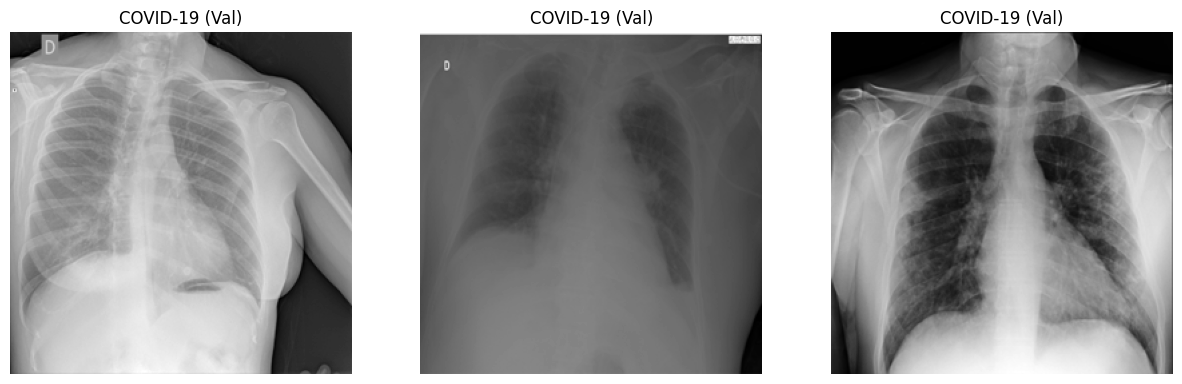

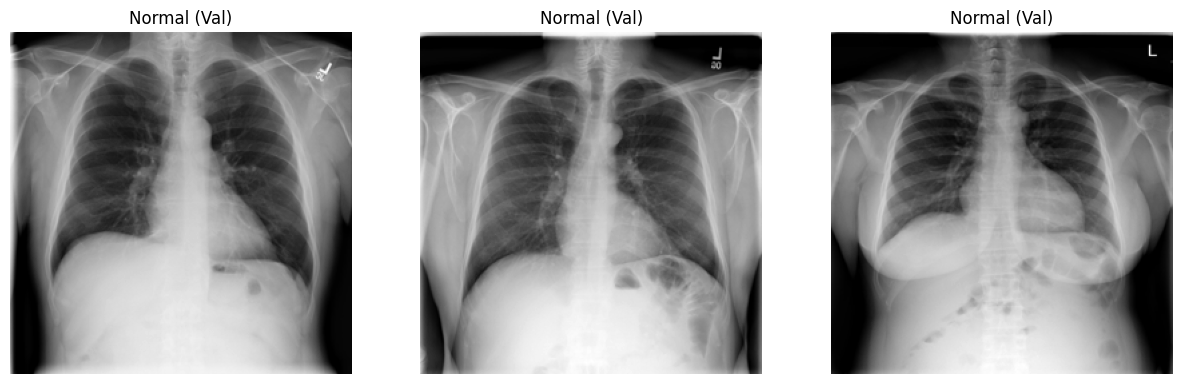

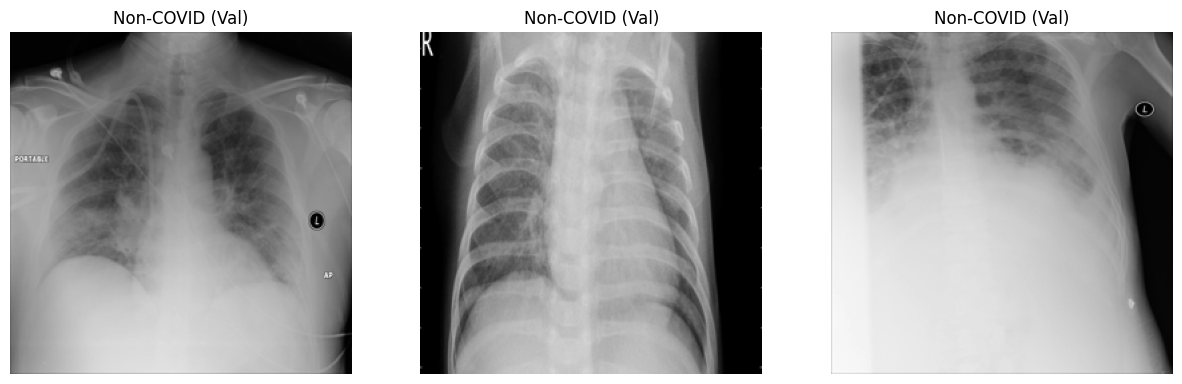

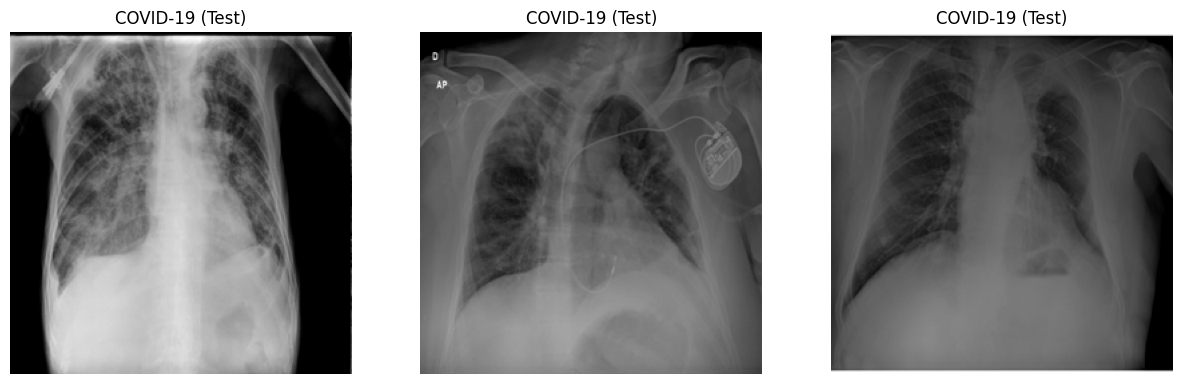

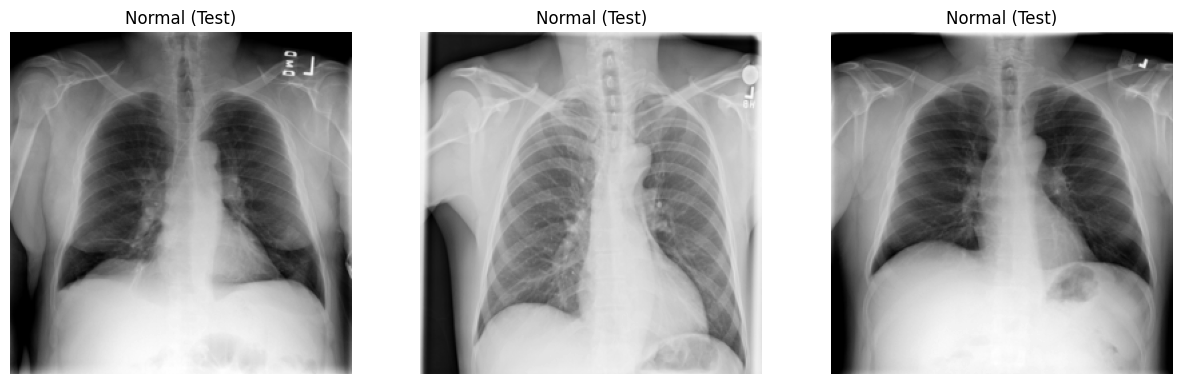

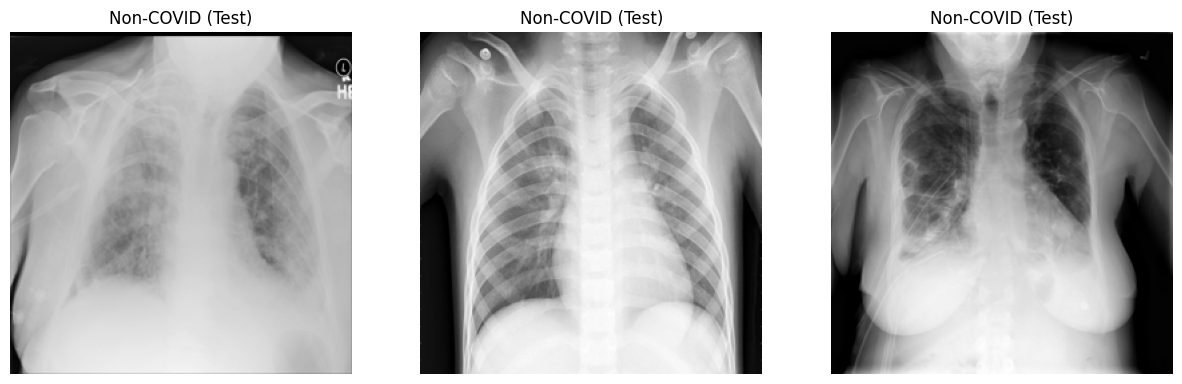

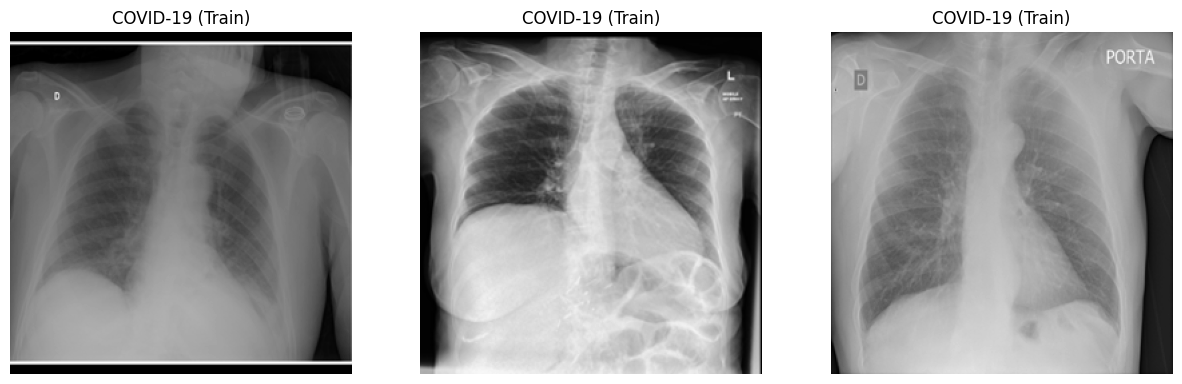

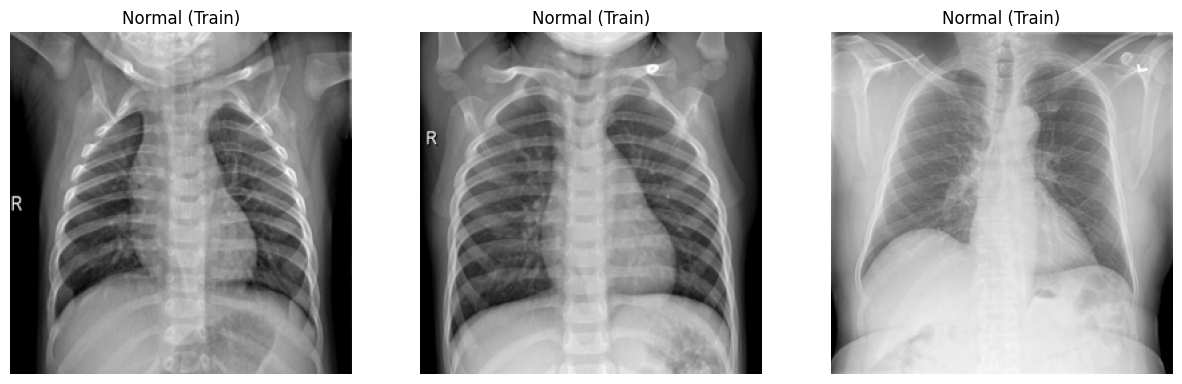

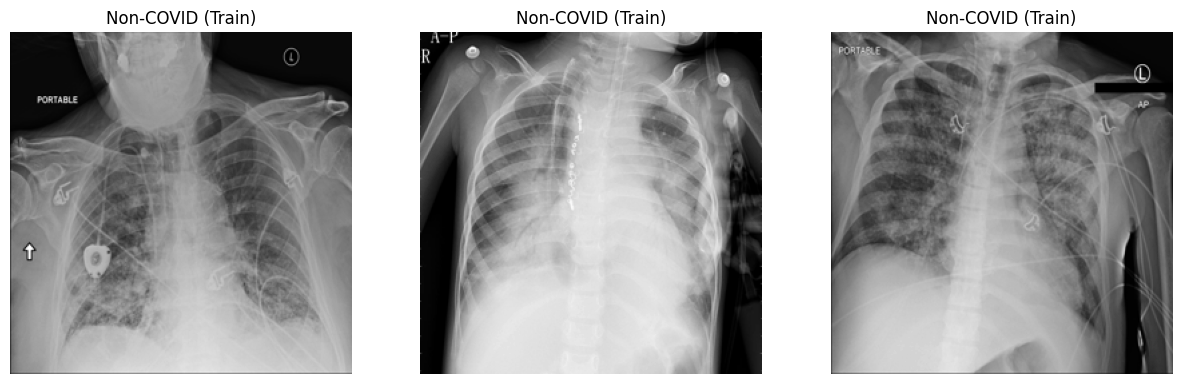

In the set Val, there are 1903 images of COVID-19
In the set Val, there are 1712 images of Normal
In the set Val, there are 1802 images of Non-COVID
In the set Test, there are 2395 images of COVID-19
In the set Test, there are 2140 images of Normal
In the set Test, there are 2253 images of Non-COVID
In the set Train, there are 7658 images of COVID-19
In the set Train, there are 6849 images of Normal
In the set Train, there are 7208 images of Non-COVID

There are 11956 COVID images found, 100.00% of the original dataset from Kaggle.
There are 11263 non-COVID images, 100.00% of the original dataset from Kaggle.
There are 10701 normal images, 100.00% of the original dataset from Kaggle.


In [7]:
check_data_integrity(destination_path=source_images_path, sets=sets, groups=groups, ref_covid=11956, ref_noncovid=11263, ref_normal=10701)

#### Data and folders structure for the model 

A specific data structure is expected for the model: one folder per set (Val, Test, Train) and a subfolder per group containing all the images. Therefore, this directory structure must be replicated for both the images and the masked images.

##### Raw images

In [8]:
copy_images(
    base_path=source_images_path , 
    destination_path=images_path, 
    sets=sets, 
    groups=groups, 
    folders=['images'],
    replace=False)

The directory /kaggle/working/COVID-EX-Qu-dataset/model/images/Val/COVID-19/images already exists.
The directory /kaggle/working/COVID-EX-Qu-dataset/model/images/Val/Normal/images already exists.
The directory /kaggle/working/COVID-EX-Qu-dataset/model/images/Val/Non-COVID/images already exists.
The directory /kaggle/working/COVID-EX-Qu-dataset/model/images/Test/COVID-19/images already exists.
The directory /kaggle/working/COVID-EX-Qu-dataset/model/images/Test/Normal/images already exists.
The directory /kaggle/working/COVID-EX-Qu-dataset/model/images/Test/Non-COVID/images already exists.
The directory /kaggle/working/COVID-EX-Qu-dataset/model/images/Train/COVID-19/images already exists.
The directory /kaggle/working/COVID-EX-Qu-dataset/model/images/Train/Normal/images already exists.
The directory /kaggle/working/COVID-EX-Qu-dataset/model/images/Train/Non-COVID/images already exists.


##### CLAHE Normalized images

Apply CLAHE on images in 'images_path' and save the results in 'clahe_images_path'.

In [9]:
def apply_clahe_normalization(img):
    """
    Apply CLAHE normalization to an input image.

    Args:
        img (numpy.ndarray): Input image, either in grayscale or RGB format.

    Returns:
        numpy.ndarray: CLAHE normalized image.

    Raises:
        ValueError: If the input image is None or not a valid image.
    """
    if img is None:
        raise ValueError("No image data received!")

    if not isinstance(img, np.ndarray):
        raise ValueError("Input must be a numpy.ndarray")

    # Convert image to grayscale if it's not already
    if len(img.shape) == 3 and img.shape[2] == 3:  # RGB image
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    elif len(img.shape) != 2:  # Not a grayscale or RGB image
        raise ValueError("Input image must be either grayscale or RGB")

    # Ensure image is of type uint8 (required for CLAHE)
    if img.dtype != np.uint8:
        img = img.astype('uint8')

    # Apply CLAHE transformation
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    img = clahe.apply(img)

    return img

In [10]:
def copy_and_clahe_images(base_path, destination_path, sets, groups, folders, replace=False):
    """
    Copy and apply CLAHE normalization on image directories from a base path to a destination path for specified sets and groups.

    Args:
        base_path (str): The base directory containing image data organized by sets and groups.
        destination_path (str): The target directory where image data will be copied.
        sets (list): A list of sets, e.g., ['Val', 'Test', 'Train'].
        groups (list): A list of groups, e.g., ['COVID-19', 'Normal', 'Non-COVID'].
        folders (list): A list of image types inside 'groups' folders, e.g., ['images', 'lung masks'].
        replace (bool): If True, existing directories at the destination will be replaced.

    If the destination directory already exists and replace is False,
    the function prints a message indicating that the directory exists and skips the copying process.
    """
    for sett in sets:
        for group in groups:
            for folder in folders:
                base_dir = os.path.join(base_path, sett, group, folder)
                destination_dir = os.path.join(destination_path, sett, group, folder)
                
                if os.path.exists(destination_dir):
                    if replace:
                        shutil.rmtree(destination_dir)
                        os.makedirs(destination_dir)
                        print(f"Replaced the directory {destination_dir}")
                    else:
                        print(f"The directory {destination_dir} already exists.")
                        continue
                else:
                    os.makedirs(destination_dir)
                    print(f"Copied to {destination_dir}")
                
                # Process each image file individually
                for filename in tqdm(os.listdir(base_dir)):
                    base_file_path = os.path.join(base_dir, filename)
                    destination_file_path = os.path.join(destination_dir, filename)
                    
                    # Read the image
                    img = cv2.imread(base_file_path, cv2.IMREAD_UNCHANGED)
                    if img is not None:
                        # Apply CLAHE normalization
                        normalized_img = apply_clahe_normalization(img)
                        
                        # Normalize the image to [0, 1]
#                         img = img.astype('float32') / 255.0
                        
                        # Save the normalized image
                        cv2.imwrite(destination_file_path, normalized_img)
                    else:
                        print(f"Failed to read {source_path}")

In [11]:
copy_and_clahe_images(
    base_path=source_images_path ,
    destination_path=clahe_images_path ,
    sets=sets,
    groups=groups,
    folders=['images'],
    replace=False
)

The directory /kaggle/working/COVID-EX-Qu-dataset/model/normalized_images/Val/COVID-19/images already exists.
The directory /kaggle/working/COVID-EX-Qu-dataset/model/normalized_images/Val/Normal/images already exists.
The directory /kaggle/working/COVID-EX-Qu-dataset/model/normalized_images/Val/Non-COVID/images already exists.
The directory /kaggle/working/COVID-EX-Qu-dataset/model/normalized_images/Test/COVID-19/images already exists.
The directory /kaggle/working/COVID-EX-Qu-dataset/model/normalized_images/Test/Normal/images already exists.
The directory /kaggle/working/COVID-EX-Qu-dataset/model/normalized_images/Test/Non-COVID/images already exists.
The directory /kaggle/working/COVID-EX-Qu-dataset/model/normalized_images/Train/COVID-19/images already exists.
The directory /kaggle/working/COVID-EX-Qu-dataset/model/normalized_images/Train/Normal/images already exists.
The directory /kaggle/working/COVID-EX-Qu-dataset/model/normalized_images/Train/Non-COVID/images already exists.


##### Masked CLAHE normalized images

Apply masks on CLAHE normalized images in 'clahe_images_path' and save the results in 'masked_normalized_images_path'.

In [12]:
def apply_black_mask(image, mask):
    """
    Apply a black mask to an image, keeping the content in white areas of the mask.
    
    Args:
        image (numpy.ndarray): The original image.
        mask (numpy.ndarray): The mask image, where white areas will be kept and black areas masked.
    
    Returns:
        numpy.ndarray: The resulting image with the mask applied.
    """
    # Resize the mask to match the dimensions of the image (if necessary)
    if image.shape[:2] != mask.shape[:2]:
        mask = cv2.resize(mask, (image.shape[1], image.shape[0]))

    # Perform bitwise AND operation to keep content in white areas of the mask
    masked_content = cv2.bitwise_and(image, image, mask=mask)

    # Create a black image of the same size as the original image
    black_image = np.zeros_like(image)

    # Perform bitwise AND operation to keep black areas of the mask
    black_areas = cv2.bitwise_and(black_image, black_image, mask=mask)

    # Combine the masked content and black areas using bitwise OR operation
    masked_image = cv2.bitwise_or(masked_content, black_areas)
   
    return masked_image

In [13]:
def dilate_and_apply_black_mask(mask, nb_pixels, image, file, masked_image_path):    
    """
    Apply the apply_black_mask function with a dilated mask and save the resulting image.
    
    Args:
        mask (numpy.ndarray): The mask image.
        nb_pixels (int): The size of the dilation kernel.
        image (numpy.ndarray): The original image.
        file (str): The filename of the original image.
        masked_image_path (str): The path where the resulting image will be saved.
    """
    kernel = np.ones((nb_pixels, nb_pixels), np.uint8)
    dilated_mask = cv2.dilate(mask, kernel)

    masked_image = apply_black_mask(image=image, mask=dilated_mask)
    
    file_name = "masked_" + file
    output_path = os.path.join(masked_image_path, file_name)
    
    cv2.imwrite(output_path, masked_image)
    

In [14]:
def apply_mask(destination_path, sets, groups, replace=False):
    """
    Copy and apply the corresponding mask on image directories from a base path to a destination path for specified sets and groups.

    Args:
        base_path (str): The base directory containing image data organized by sets and groups.
        destination_path (str): The target directory where image data will be copied.
        sets (list): A list of sets, e.g., ['Val', 'Test', 'Train'].
        groups (list): A list of groups, e.g., ['COVID-19', 'Normal', 'Non-COVID'].
        replace (bool): If True, existing directories at the destination will be replaced.

    If the destination directory already exists and replace is False,
    the function prints a message indicating that the directory exists and skips the copying process.
    """
    for sett in sets:
        print(sett)
        for group in groups:
            print(group)
            base_mask_dir = os.path.join(source_images_path , sett, group, 'lung masks')
            base_image_dir = os.path.join(clahe_images_path , sett, group, 'images')
            destination_dir = os.path.join(destination_path, sett, group, 'images')
                
            if os.path.exists(destination_dir):
                if replace:
                    shutil.rmtree(destination_dir)
                    os.makedirs(destination_dir)
                    print(f"Replaced the directory {destination_dir}")
                else:
                    print(f"The directory {destination_dir} already exists.")
                    continue
            else:
                os.makedirs(destination_dir)
                print(f"Copied to {destination_dir}")

            for filename in tqdm(os.listdir(base_mask_dir)):

                base_mask_path = os.path.join(base_mask_dir, filename)
                base_image_path = os.path.join(base_image_dir, filename)
                
                image = cv2.imread(base_image_path, cv2.IMREAD_GRAYSCALE)
                mask = cv2.imread(base_mask_path, cv2.IMREAD_GRAYSCALE)               
                
                if image is None:
                    print("Error: Unable to read image file")
                    print(image_file, "\n",  mask_file)
                    exit()
                elif mask is None:
                    print("Error: Unable to read mask file")
                    print(image_file, "\n",  mask_file)
                    exit()
                    
                dilate_and_apply_black_mask(
                    mask=mask, 
                    nb_pixels=3, 
                    image=image, 
                    file=filename,
                    masked_image_path=destination_dir)

In [15]:
apply_mask(
    destination_path=masked_normalized_images_path , 
    sets=sets, 
    groups=groups, 
    replace=False)

Val
COVID-19
The directory /kaggle/working/COVID-EX-Qu-dataset/model/masked_normalized_images/Val/COVID-19/images already exists.
Normal
The directory /kaggle/working/COVID-EX-Qu-dataset/model/masked_normalized_images/Val/Normal/images already exists.
Non-COVID
The directory /kaggle/working/COVID-EX-Qu-dataset/model/masked_normalized_images/Val/Non-COVID/images already exists.
Test
COVID-19
The directory /kaggle/working/COVID-EX-Qu-dataset/model/masked_normalized_images/Test/COVID-19/images already exists.
Normal
The directory /kaggle/working/COVID-EX-Qu-dataset/model/masked_normalized_images/Test/Normal/images already exists.
Non-COVID
The directory /kaggle/working/COVID-EX-Qu-dataset/model/masked_normalized_images/Test/Non-COVID/images already exists.
Train
COVID-19
The directory /kaggle/working/COVID-EX-Qu-dataset/model/masked_normalized_images/Train/COVID-19/images already exists.
Normal
The directory /kaggle/working/COVID-EX-Qu-dataset/model/masked_normalized_images/Train/Normal/i

##### Check processed images

In [16]:
def display_random_images_from_sets(base_path, sets, groups, num_images=3):
    """
    Display random images from each set and group in the specified base path.

    Args:
        base_path (str): The base directory containing the images.
        sets (list): A list of sets, e.g., ['Val', 'Test', 'Train'].
        groups (list): A list of groups, e.g., ['COVID-19', 'Normal', 'Non-COVID'].
        num_images (int): The number of random images to display from each set and group.
    """
    for sett in sets:
        for group in groups:
            image_dir = os.path.join(base_path, sett, group, 'images')
            all_images = os.listdir(image_dir)
            random_images = random.sample(all_images, min(len(all_images), num_images))
            
            plt.figure(figsize=(15, 5))
            plt.suptitle(f"{sett} - {group}", fontsize=16)
            
            for i, image_name in enumerate(random_images):
                image_path = os.path.join(image_dir, image_name)
                image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
                plt.subplot(1, num_images, i + 1)
                plt.imshow(image, cmap='gray')
                plt.title(image_name)
                plt.axis('off')
            
            plt.show()

In [ ]:
display_random_images_from_sets(base_path=images_path, sets=sets, groups=groups, num_images=1)

In [ ]:
display_random_images_from_sets(base_path=clahe_images_path, sets=sets, groups=groups, num_images=1)

In [ ]:
display_random_images_from_sets(base_path=masked_normalized_images_path, sets=sets, groups=groups, num_images=1)

## Specific part: Model tuning

### Data generator

In [18]:
# pre processing pour DenseNet121
# d'apres Keras : input shape has to be (224, 224, 3)
# normalisation : deja fait
# densent est construit pour fonctionner en rgb : l faut donc repliquer la couche 3x comme les radios sont en gris

def preprocess_image(img):
    """
    Preprocess the image for DenseNet121 input.

    Args:
        img (numpy.array): Input image array.

    Returns:
        numpy.array: Preprocessed image array.
    """
    if img is None:
        raise ValueError("No image data received!")

    # Convert grayscale to RGB only if the image is grayscale
    if len(img.shape) == 2 or img.shape[2] == 1:  # Check if the image is grayscale
        img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
    
    # Rescale pixel values to [0, 1]
    img = img / 255.0

    return img

In [20]:
# Initialize the ImageDataGenerator with the preprocessing function

datagen = ImageDataGenerator(
    preprocessing_function=preprocess_image
)

In [21]:
# Preparation of the data set using image generator

def data_generator(data_path:str, dataset:str, shuffle, batch_size=32):
    """
    Generates batches of tensor image data with real-time data augmentation.

    The data will be looped over (in batches) indefinitely.

    Args:
        data_path (str): Main directory name
        dataset (str): The subdirectory name (e.g., 'Train', 'Test', 'Val') within the destination path which contains the image data.
        shuffle (bool): Whether to shuffle the images before outputting to the batch.
        batch_size (int): Number of images to be included in each batch (default is 32, to optimize resources and a slow convergence for a better generalization).

    Returns:
        DirectoryIterator: An iterator that returns batches of preprocessed images and labels as per the specified batch size and target size.
    """
    generator = datagen.flow_from_directory(
        directory=os.path.join(data_path, dataset), # images stored in directories that represent their class labels
        target_size=(224, 224), # resizes all images to 224x224 pixels
        batch_size=batch_size, # defines how many images are processed at once
        class_mode='sparse', #'categorical' converts class labels to one-hot encoded vectors
        color_mode='rgb',  # Ensure images are loaded as grayscale
        shuffle=shuffle)

    return generator

In [23]:
def display_sample_images(data_path, groups, sets, num_samples=3):
    """
    Displays sample images for each class from each dataset.

    Args:
        groups (list): List of class names, e.g., ['COVID-19', 'Normal', 'Non-COVID'].
        sets (list): List of dataset names, e.g., ['Val', 'Test', 'Train'].
        num_samples (int): Number of images to display per class.
    """
    for set_name in sets:
        print(f"--- Displaying images from the {set_name} set ---")
        generator = data_generator(data_path=data_path, dataset=set_name, shuffle=False, batch_size=32)  # Batch size can be adjusted if necessary
        for group in groups:
            print(f"Class: {group}")
            found = 0
            images, labels = [], []
            # Reset the generator to ensure reproducibility
            generator.reset()
            for img_batch, label_batch in generator:
                for img, label in zip(img_batch, label_batch):
                    if generator.class_indices[group] == label:
                        images.append(img)
                        labels.append(label)
                        found += 1
                        if found >= num_samples:
                            break
                if found >= num_samples:
                    break
            # Display the images
            fig, axes = plt.subplots(1, num_samples, figsize=(15, 5))
            for i in range(num_samples):
                axes[i].imshow(images[i].squeeze())
                axes[i].axis('off')
                axes[i].set_title(f"{group}")
            plt.show()


#### Masked CLAHE images

In [26]:
train_data_generator_clahe_mask = data_generator(data_path=masked_normalized_images_path, dataset="Train", shuffle=True)
test_data_generator_clahe_mask = data_generator(data_path=masked_normalized_images_path, dataset="Test", shuffle=False) # shuffle=False argument is very important for model evaluation
val_data_generator_clahe_mask = data_generator(data_path=masked_normalized_images_path, dataset="Val", shuffle=False)

Found 21715 images belonging to 3 classes.
Found 6788 images belonging to 3 classes.
Found 5417 images belonging to 3 classes.


In [27]:
for x_batch, y_batch in data_generator(data_path=masked_normalized_images_path, dataset='Train', shuffle=True):
    print(x_batch.shape)  # Should show (32, 224, 224, 3) if full batch
    print(y_batch.shape)  # Should show (32, num_classes) for one-hot encoded labels
    break  # Just check the first batch

Found 21715 images belonging to 3 classes.
(32, 224, 224, 3)
(32,)


In [32]:
# display_sample_images(data_path=masked_normalized_images_path, groups=groups, sets=sets)

### Model building

In [28]:
def build_model(hp):

    # Load the DenseNet121 base model, pre-trained on ImageNet
    base_model = DenseNet121(
        include_top=False, # top layers (classifiers) used to train the models on the original classes are not included
        weights='imagenet', # use the pre-training on ImageNet
        input_shape=(224, 224, 3))

    # Freeze the convolutional base to reuse the learned features
    for layer in base_model.layers:
        layer.trainable = False

    model = keras.Sequential([
        base_model,
        GlobalAveragePooling2D(name='global_avg_pooling2d'),
        Dense(
            units=hp.Int('units_1', min_value=128, max_value=1024, step=128),
            activation='relu',
            name='dense_a1'
        ),
        Dropout(rate=hp.Float('dropout_1', min_value=0.3, max_value=0.7, step=0.1), name='dropout_a1'), # increase drop out rate to prevent overfitting
        Dense(
            units=hp.Int('units_2', min_value=64, max_value=256, step=64),
            activation='relu',
            name='dense_a2'
        ),
        Dropout(rate=hp.Float('dropout_2', min_value=0.3, max_value=0.7, step=0.1), name='dropout_2'),
        Dense(3, activation='softmax', name='output')
    ])

    # Compile the model
    model.compile(
        optimizer=Adam(learning_rate=hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='LOG')),
        loss='sparse_categorical_crossentropy', #
        metrics=['accuracy']
    )

    return model

### Tuner

In [29]:
# callback: Early stopping to speed up tuning
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True) # restore_best_weights : garde les weighs de l'epoch avec la meilleure val_loss

#### Masked CLAHE images

In [ ]:
# instanciate the tuner

tuner = BayesianOptimization(
    build_model,
    objective='val_accuracy',
    max_trials=4, # Total number of trials including both initial random trials and subsequent Bayesian-optimized trials
    num_initial_points=2, # Number of initial random trials before Bayesian optimization starts
    directory='/content/working/COVID-EX-Qu-dataset',
    project_name='densenet121_tuning_masked_clahe',
    overwrite=True  # Set to False to load existing data or resume previous search
)

In [36]:
# Perform hyperparameter tuning
tuner.search(train_data_generator_clahe_mask,
             validation_data=val_data_generator_clahe_mask,
             epochs=10,
             callbacks=[stop_early])

Trial 4 Complete [00h 11m 15s]
val_accuracy: 0.8484401106834412

Best val_accuracy So Far: 0.8484401106834412
Total elapsed time: 00h 41m 01s


In [ ]:
# Get the optimal hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0] # num_trials=1 pour selectionner la meilleure configuration d'hyperparameters, [0] pour selectionner le 1ere element (la liste n'en contient qu'un)

# Print all best hyperparameters
for hp in best_hps.space:
    print(f"The best {hp.name} is {best_hps.get(hp.name)}")

print(f"The best learning rate is {best_hps.get('learning_rate')}")

# The best units_1 is 512
# The best dropout_1 is 0.5
# The best units_2 is 128
# The best dropout_2 is 0.5
# The best learning_rate is 0.0013662916570530504
# The best learning rate is 0.0013662916570530504